## ThinkDSP

This notebook contains solutions to exercises in Chapter 7: Discrete Fourier Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [3]:
import numpy as np
PI2 = 2 * np.pi
import matplotlib.pyplot as plt

False


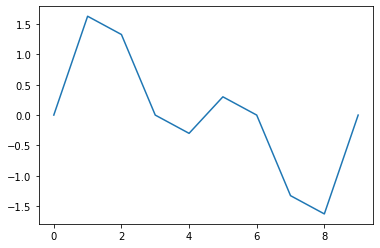

In [92]:
# Wuyang exercise 07/10/2022
my_data = np.sin(PI2 * np.linspace(0,100, num=10)) + np.sin(PI2 * 2 * np.linspace(0,100, num=10))
def approx_equal(a, b, tol=1e-10):
    return np.sum(np.abs(a-b)) < tol

def my_fun(xn, n, k, N):
    return xn * np.exp( - PI2 * 1j / N * n * k)

def my_fft(dataIn):
    """
    This function does not work well if the sample size is not an int power of 2
    """
    # Step 1: Split
    N = len(dataIn)
    if N == 1:
        return dataIn
    
    data_e = dataIn[0::2]
    N_e = len(data_e)
    data_o = dataIn[1::2]
    N_o = len(data_o)
    # print(N_e > N_o)
    
    # Step 2: Recursive calculate the FFT of splits
    dft_e = my_fft(data_e)
    dft_o = my_fft(data_o)
    
    # Step 3: Apply Danielson-Lanczox Lemma
    dft_n_1 = dft_e[:N_o] + np.array( [np.exp(-PI2*k/N*1j ) * dft_o[k] for k in range(N_o)] )
    dft_n_2 = dft_e[:N_o] - np.array( [np.exp(-PI2*k/N*1j ) * dft_o[k] for k in range(N_o)] ) 
    if N_o < N_e:
        # print('N:',N, ', (N-1)/2:', (N-1)/2)
        mid = np.sum( [ my_fun(x,n, (N-1)/2, N) for x,n in zip(dataIn, range(N))])
        # print('mid', mid)
        results = list(dft_n_1) + [mid] + list(dft_n_2)
    else:
        results = list(dft_n_1) + list(dft_n_2)
    
    # print('result length:', len(results))
    return results

plt.plot(my_data)
# print(np.abs(my_fft(my_data)-np.fft.fft(my_data)))

print(approx_equal(my_fft(my_data), np.fft.fft(my_data)))

def my_fft2(dataIn):
    # by definition
    N = len(dataIn)
    return np.array( [ np.sum( [my_fun(x, n, k, N) for x, n in zip(dataIn, range(N))] ) for k in range(N) ])

# print(approx_equal(my_fft2(my_data), np.fft.fft(my_data)))
# print(approx_equal(my_fft2(my_data), np.array(my_fft(my_data))))

In [74]:
a = [2,3,4,2,5 ]
a[:3] +[100] + a[3:]

[2, 3, 4, 100, 2, 5]

## Exercise 1

In this chapter, I showed how we can express the DFT and inverse DFT
as matrix multiplications.  These operations take time proportional to
$N^2$, where $N$ is the length of the wave array.  That is fast enough
for many applications, but there is a faster
algorithm, the Fast Fourier Transform (FFT), which takes time
proportional to $N \log N$.

The key to the FFT is the Danielson-Lanczos lemma:

$DFT(y)[n] = DFT(e)[n] + \exp(-2 \pi i n / N) DFT(o)[n]$

Where $ DFT(y)[n]$ is the $n$th element of the DFT of $y$; $e$ is the even elements of $y$, and $o$ is the odd elements of $y$.

This lemma suggests a recursive algorithm for the DFT:

1. Given a wave array, $y$, split it into its even elements, $e$, and its odd elements, $o$.

2. Compute the DFT of $e$ and $o$ by making recursive calls.

3. Compute $DFT(y)$ for each value of $n$ using the Danielson-Lanczos lemma.

For the base case of this recursion, you could wait until the length
of $y$ is 1.  In that case, $DFT(y) = y$.  Or if the length of $y$
is sufficiently small, you could compute its DFT by matrix multiplication,
possibly using a precomputed matrix.

Hint: I suggest you implement this algorithm incrementally by starting
with a version that is not truly recursive.  In Step 2, instead of
making a recursive call, use `dft` or `np.fft.fft`.  Get Step 3 working,
and confirm that the results are consistent with the other
implementations.  Then add a base case and confirm that it works.
Finally, replace Step 2 with recursive calls.

One more hint: Remember that the DFT is periodic; you might find `np.tile` useful.

You can read more about the FFT at https://en.wikipedia.org/wiki/Fast_Fourier_transform.

As the test case, I'll start with a small real signal and compute its FFT:

In [89]:
ys = [-0.5, 0.1, 0.7, -0.1]
ys = my_data
hs = np.fft.fft(ys)
print(hs)

[ 2.19824159e-13+0.00000000e+00j  1.57638094e+00-4.85160168e+00j
  2.02753214e+00-2.79065859e+00j -1.72676468e+00+1.25456797e+00j
 -1.27561348e+00+4.14471944e-01j -1.20306987e+00-1.11022302e-16j
 -1.27561348e+00-4.14471944e-01j -1.72676468e+00-1.25456797e+00j
  2.02753214e+00+2.79065859e+00j  1.57638094e+00+4.85160168e+00j]


Here's my implementation of DFT from the book:

In [90]:
def dft(ys):
    N = len(ys)
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys)
    return amps

We can confirm that this implementation gets the same result.

In [103]:
hs2 = dft(ys)
np.sum(np.abs(hs - hs2))

hs3 = my_fft(ys)
hs4 = my_fft2(ys)
print(np.sum(np.abs(hs - hs3)))
print(np.sum(np.abs(hs - hs4)))

17.528526809615162
2.079250093336111e-14


As a step toward making a recursive FFT, I'll start with a version that splits the input array and uses np.fft.fft to compute the FFT of the halves.

In [98]:
def fft_norec(ys):
    N = len(ys)
    He = np.fft.fft(ys[::2])
    print(len(He))
    Ho = np.fft.fft(ys[1::2])
    print(len(Ho))
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2)

And we get the same results:

In [104]:
hs3 = fft_norec(ys)
np.sum(np.abs(hs - hs3))

5
5


4.842208363562238e-15

Finally, we can replace `np.fft.fft` with recursive calls, and add a base case:

In [101]:
def fft(ys):
    N = len(ys)
    if N == 1:
        return ys
    
    He = fft(ys[::2])
    Ho = fft(ys[1::2])
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2)

And we get the same results:

In [102]:
hs4 = fft(ys)
np.sum(np.abs(hs - hs4))

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

This implementation of FFT takes time proportional to $n \log n$.  It also takes space proportional to $n \log n$, and it wastes some time making and copying arrays.  It can be improved to run "in place"; in that case, it requires no additional space, and spends less time on overhead.